In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)


In [4]:


from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant, calc_Sqw_from_SpinW_results
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()

cmap = sns.color_palette("rocket", as_cmap=True)


registered cmap: seaborn_cubehelix



In [5]:
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [6]:
from inxss.experiment import SimulatedExperiment, NeutronExperiment

In [7]:
incident_energy = 260

In [8]:
q_grid = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Qlist_0.csv', delimiter=',')
w_grid_edges = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Elist_0.csv', delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2

Syy = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Syy_withBroadening_0.csv', delimiter=',')
Szz = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Szz_withBroadening_0.csv', delimiter=',')
Sqw = torch.from_numpy(calc_Sqw_from_SpinW_results(q_grid, Syy, Szz))

In [9]:
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)

hklw_grid_norm = hklw_grid[...,:2].norm(dim=-1)
neutron_exp.prepare_experiment(hklw_grid)

In [10]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering_production/models/version_14896845/checkpoints/epoch=7160-step=343728.ckpt'
    ).to(device)

In [11]:
x_input = torch.zeros(hklw_grid.shape[:-1]+(5,))

x_input[...,:3] = hklw_grid[...,[0,1,3]]
x_input[...,3:] = torch.tensor([29.0, 1.68])

s_pred = []
k = 0
with torch.no_grad():
    for _x_input in tqdm(x_input.permute(3,0,1,2,4).reshape((-1, hklw_grid.shape[0], hklw_grid.shape[1], hklw_grid.shape[2], 5,))):
        # print(_x_input.shape)
        _y_output = model(_x_input.to(device), l=hklw_grid[...,k,[2]].to(device)).detach().cpu().numpy()
        s_pred.append(_y_output)
        k += 1
        # break
s_pred = np.moveaxis(np.stack(s_pred), 0, -1)

100%|██████████| 91/91 [00:09<00:00,  9.28it/s]


In [13]:
output_dict = torch.load('data/bkg_subtraction_output_260meV.pt')

In [14]:
i_inn, j_inn = np.where(output_dict['inn_ddv'] == output_dict['inn_ddv'].min())
i_mid, j_mid = np.where(output_dict['mid_ddv'] == output_dict['mid_ddv'].min())
i_out, j_out = np.where(output_dict['out_ddv'] == output_dict['out_ddv'].min())

Text(0.5, 3.722222222222216, 'Scale factor $\\lambda$')

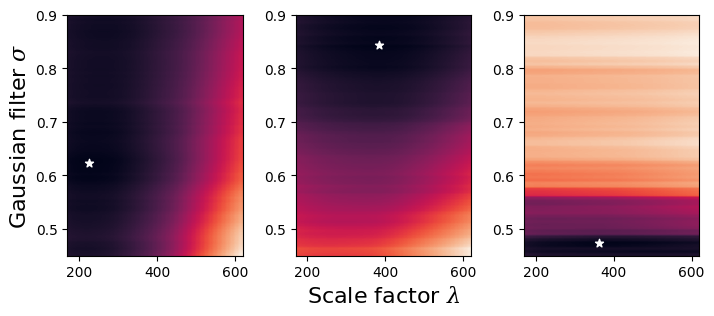

In [47]:
fig, ax = plt.subplots(1,3, figsize=(7,3))
ax[0].imshow(output_dict['inn_ddv'], 
             extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], 
             origin='lower', cmap=cmap)
ax[0].scatter(output_dict['scales'][j_inn], output_dict['sigmas'][i_inn], color='w', marker='*')
ax[1].imshow(output_dict['mid_ddv'], 
             extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], 
             origin='lower', cmap=cmap)
ax[1].scatter(output_dict['scales'][j_mid], output_dict['sigmas'][i_mid], color='w', marker='*')
ax[2].imshow(output_dict['out_ddv'], 
             extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], 
             origin='lower', cmap=cmap)
ax[2].scatter(output_dict['scales'][j_out], output_dict['sigmas'][i_out], color='w', marker='*')
ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
fig.tight_layout()

ax[0].set_ylabel('Gaussian filter $\sigma$', fontsize=16)
ax[1].set_xlabel('Scale factor $\lambda$', fontsize=16)

In [16]:
mask_exp = neutron_exp.Sqw > 1e-10
# mask_pred = (s_pred_sm > 5e-2*s_pred_sm.max()) * mask_exp.cpu().numpy()
# mask_pred = (s_pred > 1e-4*s_pred.max()) * mask_exp.cpu().numpy()

s_pred_masked_sm_inn = gaussian_filter(s_pred, output_dict['sigmas'][i_inn][0]) * mask_exp.numpy()
s_pred_masked_sm_mid = gaussian_filter(s_pred, output_dict['sigmas'][i_mid][0]) * mask_exp.numpy()
s_pred_masked_sm_out = gaussian_filter(s_pred, output_dict['sigmas'][i_out][0]) * mask_exp.numpy()

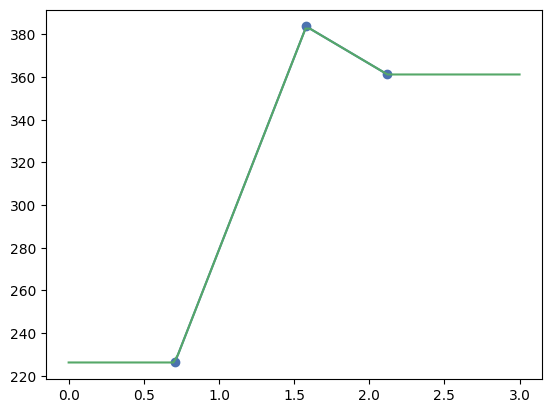

In [17]:
centers = np.array([0.5 * np.sqrt(2), np.sqrt(1.5 ** 2 + 0.5 ** 2), 1.5 * np.sqrt(2)])
scales = np.array([output_dict['scales'][j_inn][0], output_dict['scales'][j_mid][0], output_dict['scales'][j_out][0]])
from scipy.interpolate import CubicSpline

centers_sampled = np.linspace(0, 3, 100)

plt.plot(centers, scales, '-o')
plt.plot(centers_sampled, np.interp(centers_sampled, centers, scales), '-')

In [18]:
interped_scales = np.interp(hklw_grid_norm.numpy(), centers, scales)

In [19]:

total_signal = neutron_exp.Sqw.cpu().numpy()
background = total_signal.copy()

q_inn_mid = 1.1441
q_mid_out = 1.8512

mask_inn = (hklw_grid_norm <= q_inn_mid).numpy() * mask_exp.numpy()
mask_mid = (hklw_grid_norm >  q_inn_mid).numpy() * (hklw_grid_norm <=  q_mid_out).numpy() * mask_exp.numpy()
mask_out = (hklw_grid_norm >  q_mid_out).numpy() * mask_exp.numpy()

background[mask_inn] = total_signal[mask_inn] - interped_scales[mask_inn] * s_pred_masked_sm_inn[mask_inn]
background[mask_mid] = total_signal[mask_mid] - interped_scales[mask_mid] * s_pred_masked_sm_inn[mask_mid]
background[mask_out] = total_signal[mask_out] - interped_scales[mask_out] * s_pred_masked_sm_inn[mask_out]


Text(0, 0.5, '$k$')

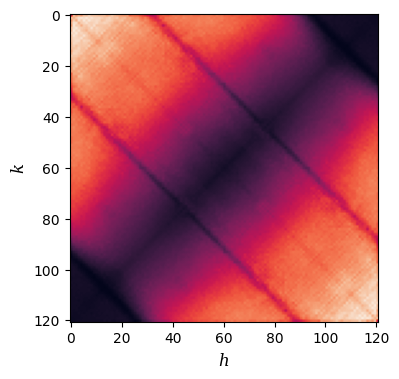

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(background.sum(-1).sum(-1), cmap=cmap)

ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$k$')

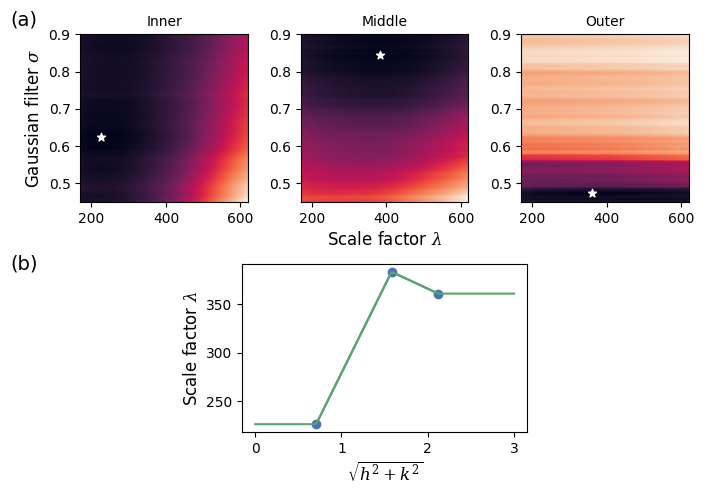

In [106]:
fig = plt.figure(figsize=(7, 5))

gs = fig.add_gridspec(2, 3)

ax = fig.add_subplot(gs[0, 0])
ax.imshow(output_dict['inn_ddv'], 
             extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], 
             origin='lower', cmap=cmap)
ax.scatter(output_dict['scales'][j_inn], output_dict['sigmas'][i_inn], color='w', marker='*')
ax.set_title('Inner')
ax.set_aspect('auto')
ax.set_ylabel('Gaussian filter $\sigma$')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(output_dict['mid_ddv'], 
             extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], 
             origin='lower', cmap=cmap)
ax.scatter(output_dict['scales'][j_mid], output_dict['sigmas'][i_mid], color='w', marker='*')
ax.set_title('Middle')
ax.set_aspect('auto')
ax.set_xlabel('Scale factor $\lambda$')

ax = fig.add_subplot(gs[0, 2])
ax.imshow(output_dict['out_ddv'], 
             extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], 
             origin='lower', cmap=cmap)
ax.scatter(output_dict['scales'][j_out], output_dict['sigmas'][i_out], color='w', marker='*')
ax.set_title('Outer')
ax.set_aspect('auto')

sub_gs = gs[1, :].subgridspec(1, 4)

ax = fig.add_subplot(sub_gs[1:3])
ax.plot(centers, scales, '-o')
ax.plot(centers_sampled, np.interp(centers_sampled, centers, scales), '-')
ax.set_xlabel(r'$\sqrt{h^{2}+k^{2}}$')
ax.set_ylabel(r'Scale factor $\lambda$')

# ax = fig.add_subplot(sub_gs[1])
# ax.imshow(background.sum(-1).sum(-1), cmap=cmap, origin='lower', extent=[-2,2,-2,2])
# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_yticks([-2, -1, 0, 1, 2])
# ax.set_xlabel(r'$h$')
# ax.set_ylabel(r'$k$')

fig.text(0, 0.95, '(a)', fontsize=14)
fig.text(0, 0.46, '(b)', fontsize=14)
# fig.text(0.55, 0.46, '(c)', fontsize=14)

fig.tight_layout()
fig.savefig('figures/bkg_subtraction_summary.pdf', bbox_inches='tight')

In [82]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="../conf"):
    cfg = compose(config_name="config_poisson")


grid_info = {
    k: [v.min().item(), v.max().item(), len(v)] for k,v in data['grid'].items()
}


mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": data['S']>0
}


psi_mask = PsiMask(**mask_config)

/tmp/ipykernel_1629930/3380802561.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../conf"):


obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [84]:
mask_demo = psi_mask.load_memmap_mask(0.0)

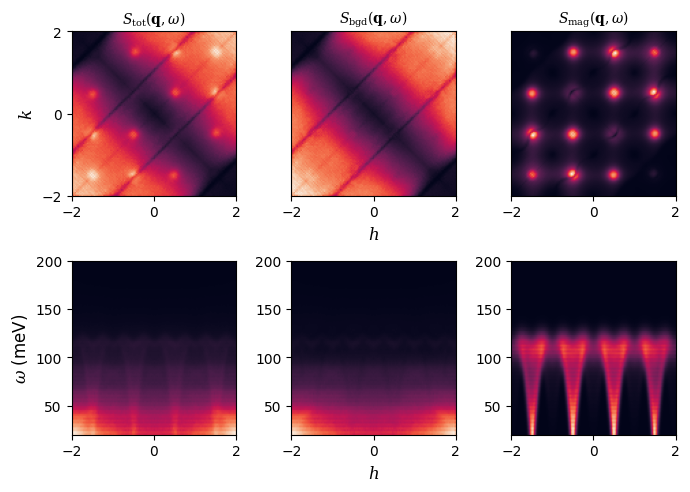

In [109]:
fig = plt.figure(figsize=(7, 5))

gs = fig.add_gridspec(2, 3)

ax = fig.add_subplot(gs[0, 0])
ax.imshow(total_signal.sum(-1).sum(-1).T, cmap=cmap, origin='lower', extent=[-2,2,-2,2])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_ylabel(r'$k$')
ax.set_title('$S_{\mathrm{tot}}(\mathbf{q},\omega)$')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(background.sum(-1).sum(-1).T, cmap=cmap, origin='lower', extent=[-2,2,-2,2])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_yticks([])
ax.set_xlabel(r'$h$')
ax.set_title('$S_{\mathrm{bgd}}(\mathbf{q},\omega)$')

ax = fig.add_subplot(gs[0, 2])
ax.imshow((total_signal - background).sum(-1).sum(-1).T, cmap=cmap, origin='lower', extent=[-2,2,-2,2])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_yticks([])
ax.set_title('$S_{\mathrm{mag}}(\mathbf{q},\omega)$')

ax = fig.add_subplot(gs[1, 0])
ax.imshow(total_signal.sum(-2).sum(-2).T, cmap=cmap, origin='lower', extent=[-2,2,20,200])
# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_ylabel(r'$\omega$ (meV)')
ax.set_aspect('auto')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(background.sum(-2).sum(-2).T, cmap=cmap, origin='lower', extent=[-2,2,20,200])
# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_xlabel(r'$h$')
ax.set_aspect('auto')

ax = fig.add_subplot(gs[1, 2])
ax.imshow(((total_signal - background)).sum(-2).sum(-2).T, cmap=cmap, origin='lower', extent=[-2,2,20,200])
# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_aspect('auto')

fig.tight_layout()
fig.savefig('figures/bkg_subtraction_demos.pdf', bbox_inches='tight')

In [76]:
data.keys()

dict_keys(['grid', 'S'])

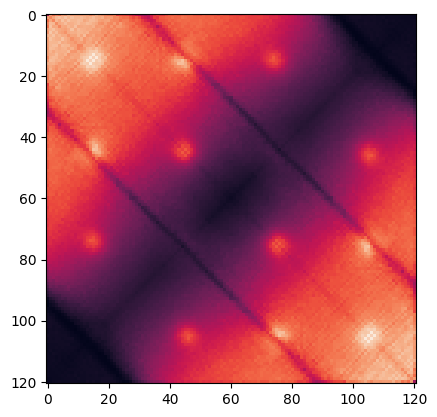

In [71]:
plt.imshow(total_signal.sum(-1).sum(-1), cmap=cmap)